(0.6655227343241373, 0.75)
(0.5296875635782877, 0.8333333333333334)
(0.4661698341369629, 0.8229166666666666)
(0.48779070377349854, 0.8125)
(0.4045660098393758, 0.875)
(0.5815770626068115, 0.8020833333333334)
(0.42664138476053876, 0.84375)
(0.403298298517863, 0.84375)
(0.34686938921610516, 0.8645833333333334)
(0.47262489795684814, 0.84375)


/tmp/ipykernel_5586/2878404106.py:166: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1,n,figsize= (8,8))


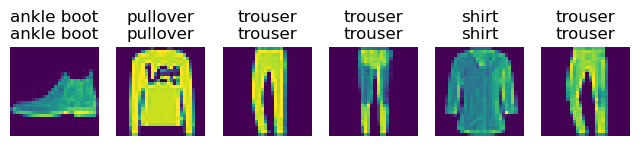

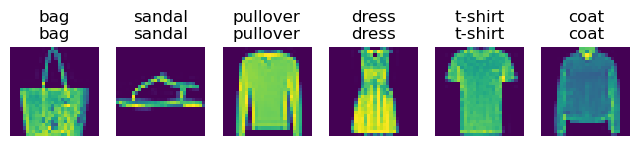

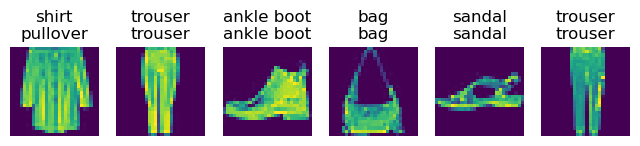

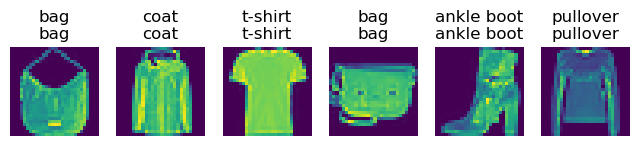

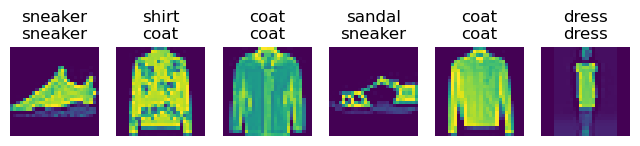

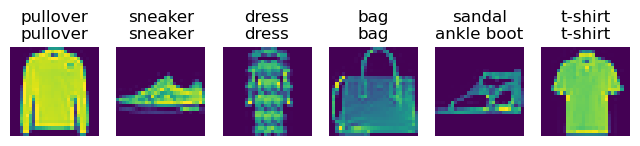

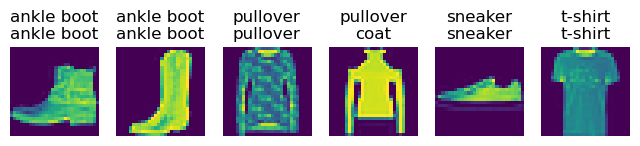

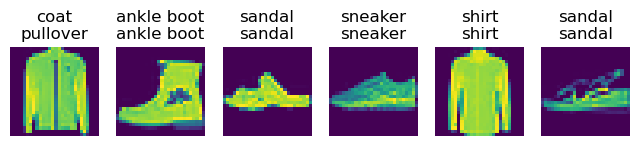

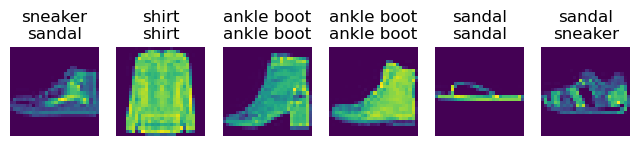

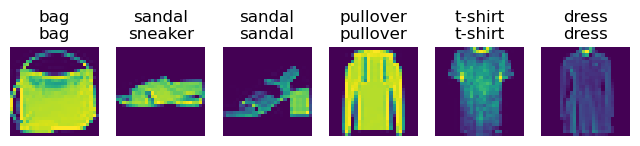

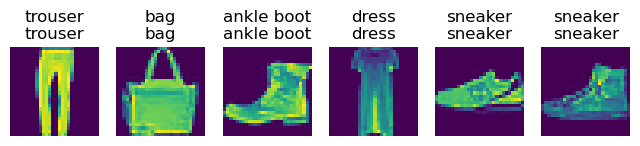

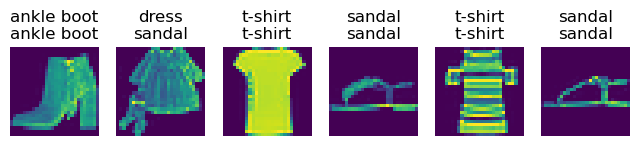

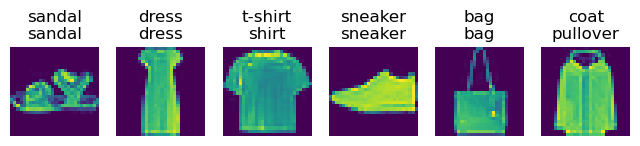

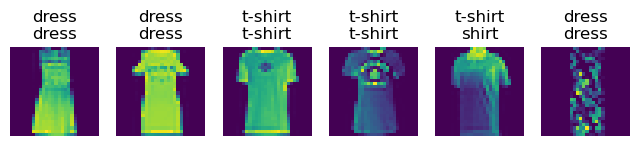

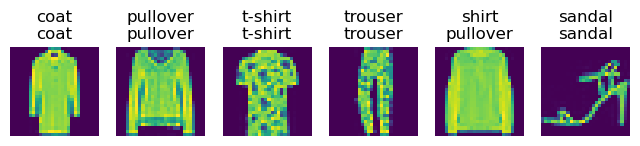

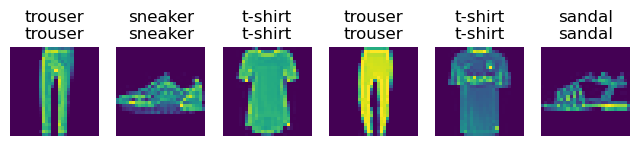

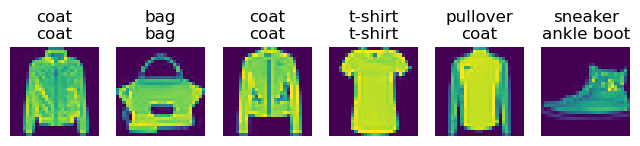

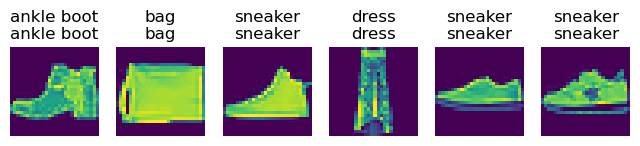

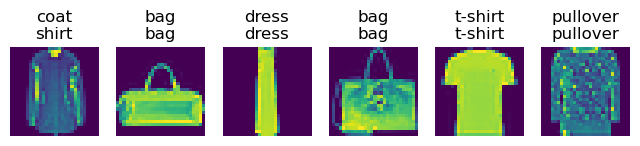

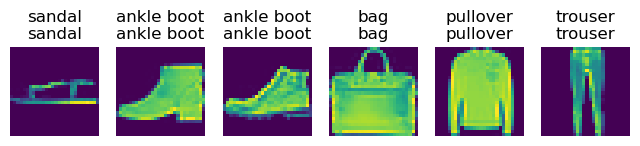

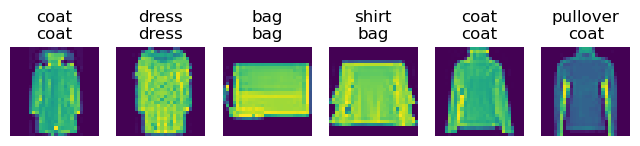

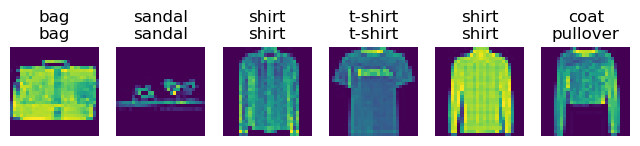

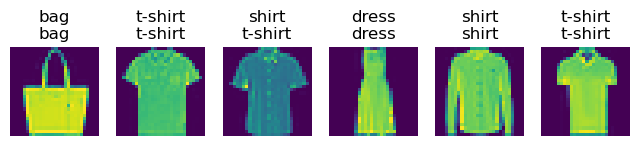

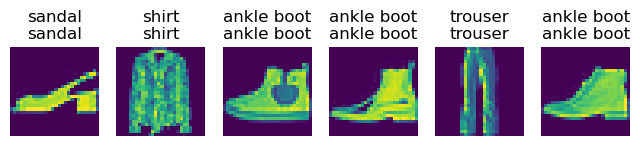

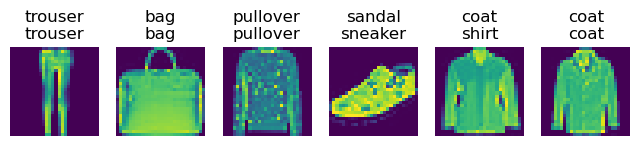

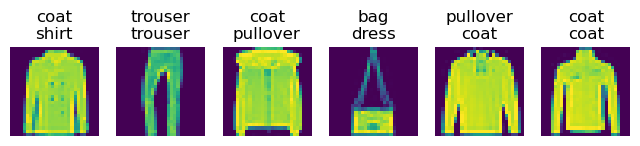

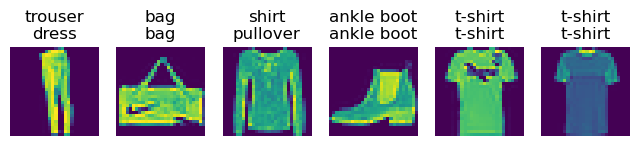

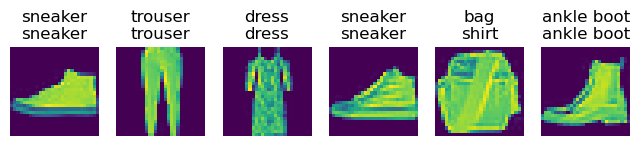

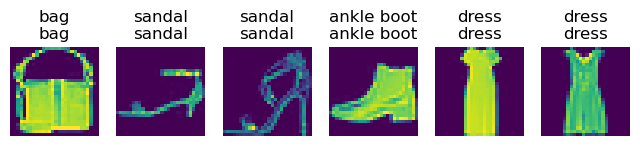

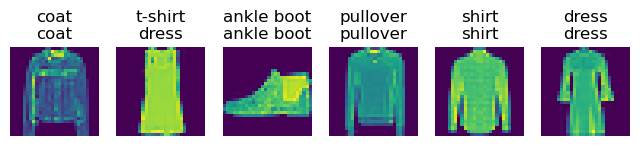

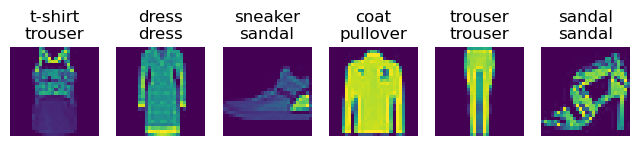

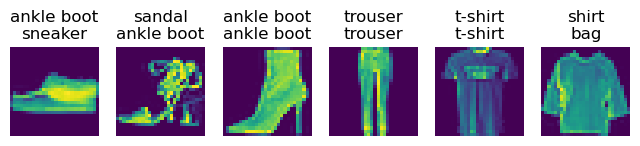

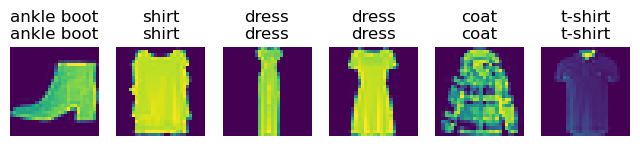

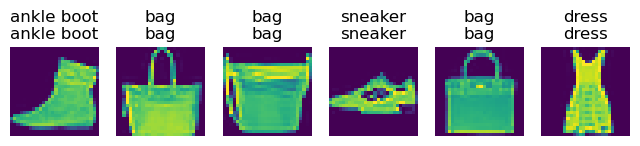

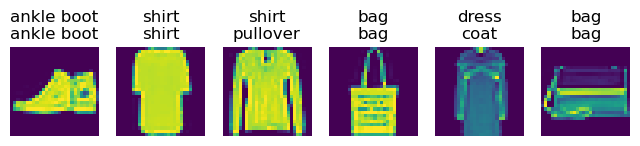

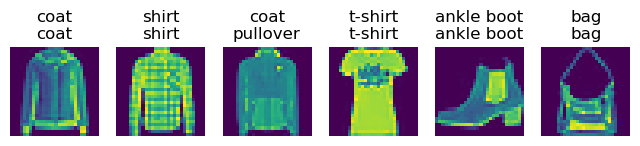

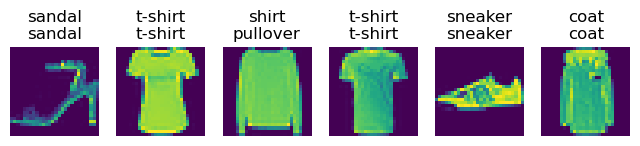

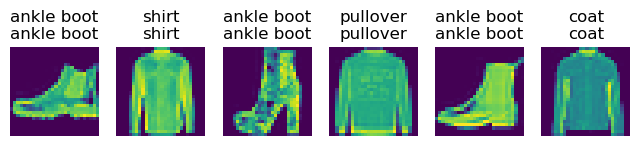

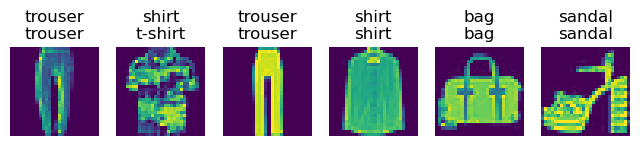

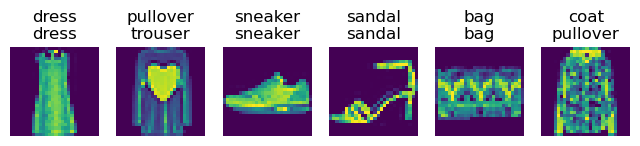

In [1]:
import sys
import torch 
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
class Accumulator: # 累加多个变量的实用程序类
    def __init__(self, n):
        self.data = [0.0]*n
    def add(self,*args) : # 在data的对应位置加上对应的数
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data=[0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
class Animator: # 绘制数据的实用程序类
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
        ylim=None, xscale='linear', yscale='linear',
        fmts=('-', 'm--', 'g-.', 'r:'), n_rows=1, n_cols=1,
        figsize=(3.5, 2.5)): 
        # xlim ylim指定x轴和y轴的范围
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(n_rows, n_cols, figsize=figsize) # 这里fig存储的是subplots画出的整个图 axes是一个二维索引数组,储存每个子图
        if n_rows * n_cols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: self.axes[0].set(
        xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim, xscale= xscale, yscale =yscale)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"): # 如果y是一个单一的单位 将它变成一个可迭代的列表 这样使函数可以处理单个数据点
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): # 如果x是一个单一的单位 将它变成一个和y同规模的可迭代的列表
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display(self.fig)
        #display(clear=True)
#小批量的Softmax回归
# 使用Fashion-MINST数据集 集中的图片大小为28*28
def get_MINST_labels(labels): # 获取训练集中的数据对应的标签 labels参数传入 MINST_train.train_labels
    text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def load_data(batch_size, resize = False):
    trans =[ transforms.ToTensor()] # 格式转换的列表 列表里的所有内容在格式转换时都会被应用
    if resize: # 如果指定了需要重置大小
        trans.insert(0,transforms.Resize(resize)) #在trans列表开头位置添加transforms.Resize类
    trans = transforms.Compose(trans) # 将trans列表中的内容整合在一起 形成一个整合类 之后可调用 transformedd_img=trans(img) 初始化img
    MINST_train = torchvision.datasets.FashionMNIST(root='./data', transform=trans, train=True, download=True)
    MINST_test = torchvision.datasets.FashionMNIST(root='./data', transform=trans, train=False, download=True)
    return (data.DataLoader(MINST_train, batch_size, shuffle=True, num_workers=16),
            data.DataLoader(MINST_test, batch_size, shuffle=False, num_workers=16))
def show_imgs(imgs, num_rows, num_cols, titles=None, scale=1.5):# 将所有图片绘制在一张表中
    """
    参数: imgs为图片集 num_rows*num_cols = 绘制的图片总数 即将所有图片展示为num_rows行num_cols列
    title为绘制出的图片标题 scale为缩放大小 如1.5为放大1.5倍绘制
    """
    figure_size = (num_cols*scale, num_rows*scale)
    _, axes = plt.subplots(num_rows,num_cols,figsize=figure_size)
    axes = axes.flatten()
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        if(torch.is_tensor(img)): #如果图片用张量存储
            ax.imshow(img.numpy())
        else: #PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False) # 取消图中的X轴上的坐标刻度和坐标数值
        ax.axes.get_yaxis().set_visible(False) # 取消图中的Y轴上的坐标刻度和坐标数值
        if(titles): # 如果绘制时指定了标题 就显示标题 否则不显示
            ax.set_title(titles[i])
    return axes
def Softmax(X): # Softmax基于随机输入,将每个元素变成非负数,依据概率原理,每行的总和为1
    """
    Softmax(X)[i][j] = exp(X[i][j]) / Sigma(X[i][k]) 即每个位置的Softmax就是这个位置的值的Exp除以这一行的Exp求和
    """
    X_exp = torch.exp(X) #Softmax的分子
    partition = X_exp.sum(1, keepdim=True) #Softmax的分母
    return X_exp / partition # 使用了广播机制
def net(X, W): # 定义模型
    return Softmax(torch.matmul(X.reshape(-1,W.shape[0]),W) + b)
def cross_entropy(y_hat, y):
    """
    交叉熵采用真实标签的预测概率的负对数似然
    y[]是一个张量,表示每个数据的正确预测的标签
    y_hat[range(len(y_hat)), y] 表达式表示对于每个y[i],找到对应的y_hat预测的概率
    比如：
    y = torch.tensor([0, 2])
    y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
    y_hat[[0, 1], y] 输出tensor([0.1000, 0.5000])
    表示 因为y中正确的标签是 0类 和 2类
    取出 y_hat中每行的y_hat[i][y[correct_label]]的概率
    """
    return -torch.log(y_hat[range(len(y_hat)), y])
def accuracy(y_hat, y): # 计算预测正确的数量
    """
    如果y_hat存储的是矩阵,假定第二个维度存储每个类的预测分数
    """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1) #取出y_hat中每一行中的最大的那个概率的索引
    cmp = y_hat.type(y.dtype) == y # 比较y_hat和y中的每个位置相不相等, 注意这之前要先把它们的类型转换为一样的 .type(dtype)函数表示将这个tensor的类型转为dtype
    return float(cmp.type(y.dtype).sum())
def evaluate_accuracy(net,data_iter): # 对于任何data_iter可访问的数据集 都可以评估模型的精度
    if isinstance(net, nn.Module):
        net.eval() # 模型设置为评估模式
    metric = Accumulator(2) # 2个位置为 正确预测数和预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X,W),y),y.numel())
    return metric[0] / metric[1]
def train_epoch(net, train_set, loss_function, updater): # 模型在训练周期中的一次训练
    """
    updater是更新模型参数的函数,接收批量大小作为参数
    updater可以是sgd函数 也可以是框架内的内置函数
    """
    if isinstance(net, nn.Module):
        net.train()
    metric = Accumulator(3) # 三个位置为 训练损失总和 训练准确数 样本数
    for X,y in train_set:
        y_hat = net(X, W) # 给出一次预测
        loss = loss_function(y_hat, y) # 计算损失
        if isinstance(updater, torch.optim.Optimizer):# updater为Pytorch框架的内置优化器
            updater.zero_grad() # 将grad置为0 因为pytorch计算梯度时会累加
            loss.mean().backward() # 计算梯度
            updater.step() # 由计算出的梯度更新参数
        else: # 使用的是定制的优化器和损失函数
            loss.sum().backward()
            updater(X.shape[0])
    metric.add(float(loss.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2] # 返回训练损失和训练精度
def train(net, train_set, test_set, loss_function, num_epochs, updater): # 训练模型
    #animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
    #                    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_set, loss_function, updater)
        print(train_metrics)
        test_accurancy = evaluate_accuracy(net, test_set)
        #animator.add(epoch + 1, train_metrics + (test_accurancy,))
    train_loss, train_accuracy = train_metrics
    #assert train_loss < 0.5, train_loss
    #assert train_accuracy <= 1 and train_accuracy > 0.7, train_accuracy
    #assert test_accurancy <= 1 and test_accurancy > 0.7, test_accurancy
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param-= learning_rate * param.grad / batch_size
            param.grad.zero_()
def updater(batch_size):
    return sgd(params=[W,b], lr = learning_rate, batch_size=batch_size)
def prediction(net, test_set,n=6): 
    for X ,y in test_set:
        _, axes = plt.subplots(1,n,figsize= (8,8))
        true_labels = get_MINST_labels(y)
        pred_labels= get_MINST_labels(net(X,W).argmax(axis = 1))
        titles = [true + '\n' + pred for true , pred in zip(true_labels,pred_labels)]
        for i in range(n):
            axes[i].imshow(X[i].reshape((28,28)))
            axes[i].set_title(titles[i])
            axes[i].axis('off')
# 预测图片类别
batch_size = 256
num_inputs = 784 # 一个图片有784个像素 即输入维度有784
num_outputs = 10 # 共有10个类别 即输出维度为10
learning_rate = 0.1
num_epochs = 10
W = torch.normal(0, 0.01, size=(num_inputs,num_outputs), requires_grad=True) # 初始化权重矩阵
b = torch.zeros(num_outputs, requires_grad=True) # 初始化偏置矩阵
train_set, test_set = load_data(batch_size)
train(net,train_set,test_set,cross_entropy,num_epochs,updater)
prediction(net, test_set)